In [31]:
pip install pandas scikit-learn


In [27]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load the remote CSV file
url = "https://gist.githubusercontent.com/jessieRWTH/45bfa0fe37755180721c939021504190/raw/74d9581c551841026cf5729bc2fd3ca72cd1923d/experimental_data_pem.csv"
df = pd.read_csv(url)


### Model1

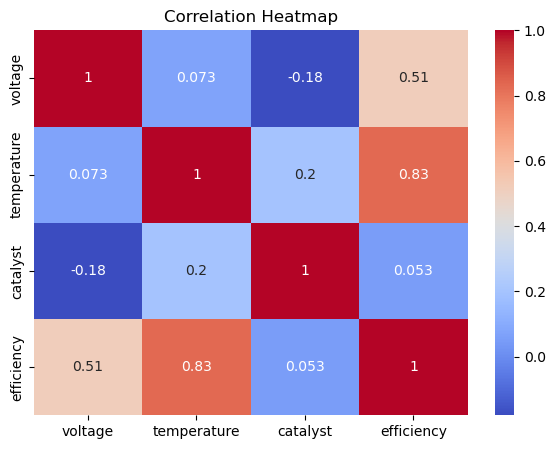

Test RMSE: 1.04
5-Fold CV RMSE: 0.87


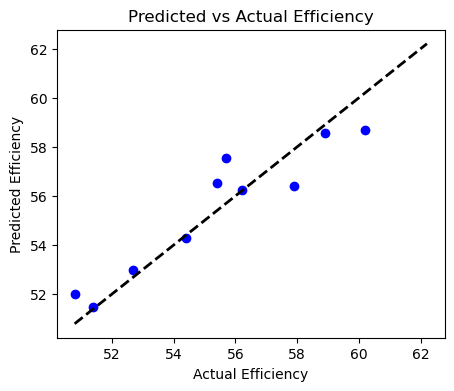

✅ Final Regression Coefficients for n8n:
{'intercept': np.float64(22.1581), 'voltage': np.float64(10.2944), 'temperature': np.float64(0.1918)}


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

# Step 1: Load and clean dataset
url = "https://gist.githubusercontent.com/jessieRWTH/45bfa0fe37755180721c939021504190/raw/74d9581c551841026cf5729bc2fd3ca72cd1923d/experimental_data_pem.csv"
df = pd.read_csv(url)

# Step 2: Standardize column names and remove missing data
df.columns = df.columns.str.strip()
df = df.rename(columns={
    'voltage_V': 'voltage',
    'temperature_°C': 'temperature',
    'efficiency_%': 'efficiency',
    'catalyst_mg/cm²': 'catalyst',
    'membrane': 'membrane'
})
df = df.dropna()

# Step 3: EDA (Optional)
plt.figure(figsize=(7, 5))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Step 4: Select features and target
X = df[['voltage', 'temperature']]
y = df['efficiency']

# Step 5: Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Build pipeline: StandardScaler + LinearRegression
model = make_pipeline(StandardScaler(), LinearRegression())
model.fit(X_train, y_train)

# Step 7: Predict and calculate RMSE manually
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Test RMSE: {rmse:.2f}")

# Step 8: Cross-validation RMSE
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_mse = -cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(cv_scores_mse)
print(f"5-Fold CV RMSE: {cv_rmse.mean():.2f}")

# Step 9: Predicted vs actual plot
plt.figure(figsize=(5, 4))
plt.scatter(y_test, y_pred, color='blue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Efficiency')
plt.ylabel('Predicted Efficiency')
plt.title('Predicted vs Actual Efficiency')
plt.show()

# Step 10: Export regression coefficients to use in n8n
reg_model = model.named_steps['linearregression']
scaler = model.named_steps['standardscaler']

# Recover true-scale coefficients from standardized model
coefs_scaled = reg_model.coef_ / scaler.scale_
intercept_scaled = reg_model.intercept_ - np.sum(coefs_scaled * scaler.mean_)

coefficients = {
    'intercept': round(intercept_scaled, 4),
    'voltage': round(coefs_scaled[0], 4),
    'temperature': round(coefs_scaled[1], 4)
}

print("✅ Final Regression Coefficients for n8n:")
print(coefficients)


# Model2

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

# Step 1: Load and clean dataset
url = "https://gist.githubusercontent.com/jessieRWTH/45bfa0fe37755180721c939021504190/raw/74d9581c551841026cf5729bc2fd3ca72cd1923d/experimental_data_pem.csv"
df = pd.read_csv(url)
df.columns = df.columns.str.strip()
df = df.rename(columns={
    'voltage_V': 'voltage',
    'temperature_°C': 'temperature',
    'efficiency_%': 'efficiency',
    'catalyst_mg/cm²': 'catalyst',
    'membrane': 'membrane'
})
df = df.dropna()

# Step 2: Select features
X = df[['voltage', 'temperature', 'catalyst', 'membrane']]
y = df['efficiency']

# Step 3: Preprocessing for numerical + categorical features
numeric_features = ['voltage', 'temperature', 'catalyst']
numeric_transformer = StandardScaler()

categorical_features = ['membrane']
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)  # ✅ 修正這裡

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


# Step 4: Build pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Step 5: Split data and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)

# Step 6: Evaluation
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse:.2f}")

# Step 7: Cross-validation RMSE
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_mse = -cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(cv_mse)
print(f"5-Fold CV RMSE: {cv_rmse.mean():.2f}")

# Step 8: Extract regression coefficients (scaled back)
reg_model = model.named_steps['regressor']
scaler = model.named_steps['preprocessor'].named_transformers_['num']
encoder = model.named_steps['preprocessor'].named_transformers_['cat']

# Get coefficient names
numeric_scaled = reg_model.coef_[:len(numeric_features)] / scaler.scale_
intercept = reg_model.intercept_ - np.sum(numeric_scaled * scaler.mean_)

encoded_feature_names = encoder.get_feature_names_out(['membrane'])
categorical_coefs = reg_model.coef_[len(numeric_features):]

# Combine all into readable dictionary
coef_dict = {
    'intercept': round(intercept, 4),
    'voltage': round(numeric_scaled[0], 4),
    'temperature': round(numeric_scaled[1], 4),
    'catalyst': round(numeric_scaled[2], 4),
}

for name, coef in zip(encoded_feature_names, categorical_coefs):
    coef_dict[name] = round(coef, 4)

print("✅ Regression Coefficients Dictionary (for n8n or report):")
print(coef_dict)


Test RMSE: 0.98
5-Fold CV RMSE: 0.91
✅ Regression Coefficients Dictionary (for n8n or report):
{'intercept': np.float64(22.5968), 'voltage': np.float64(10.21), 'temperature': np.float64(0.1946), 'catalyst': np.float64(-1.3309), 'membrane_Nafion212': np.float64(0.2059)}


In [2]:
import sklearn
print(sklearn.__version__)


1.6.1
